In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.shape

(13320, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

#### Data Cleaning

Checking the relation between feature, understand how to categorise these, and some visualisation

In [7]:
col_dict = dict()
for i in df.columns:
    col_dict[i] = df[i].value_counts().shape[0]
    
pd.DataFrame(col_dict, index=['unique_counts'])

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
unique_counts,4,81,1305,31,2688,2117,19,4,1994


In [8]:
pd.DataFrame(df.isnull().sum()).transpose()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,0,1,16,5502,0,73,609,0


In [9]:
df.groupby('area_type').agg({'price': [np.mean, np.max, np.min]})

price               
                            mean    amax   amin
area_type                                      
Built-up  Area        104.285498  2050.0   9.00
Carpet  Area           89.502356   500.0  13.00
Plot  Area            208.495486  3600.0   8.44
Super built-up  Area   92.971757  2912.0   8.00

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def render_plot(data, x=None, y=None):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
    sns.histplot(data=data, x=x, hue=y, ax=axes[0], kde=True)
    sns.scatterplot(data=data, y=x, x=y, ax=axes[1])
    sns.countplot(data=data, x=y, ax=axes[2])
    plt.tight_layout(h_pad=0.5, w_pad=1.2)

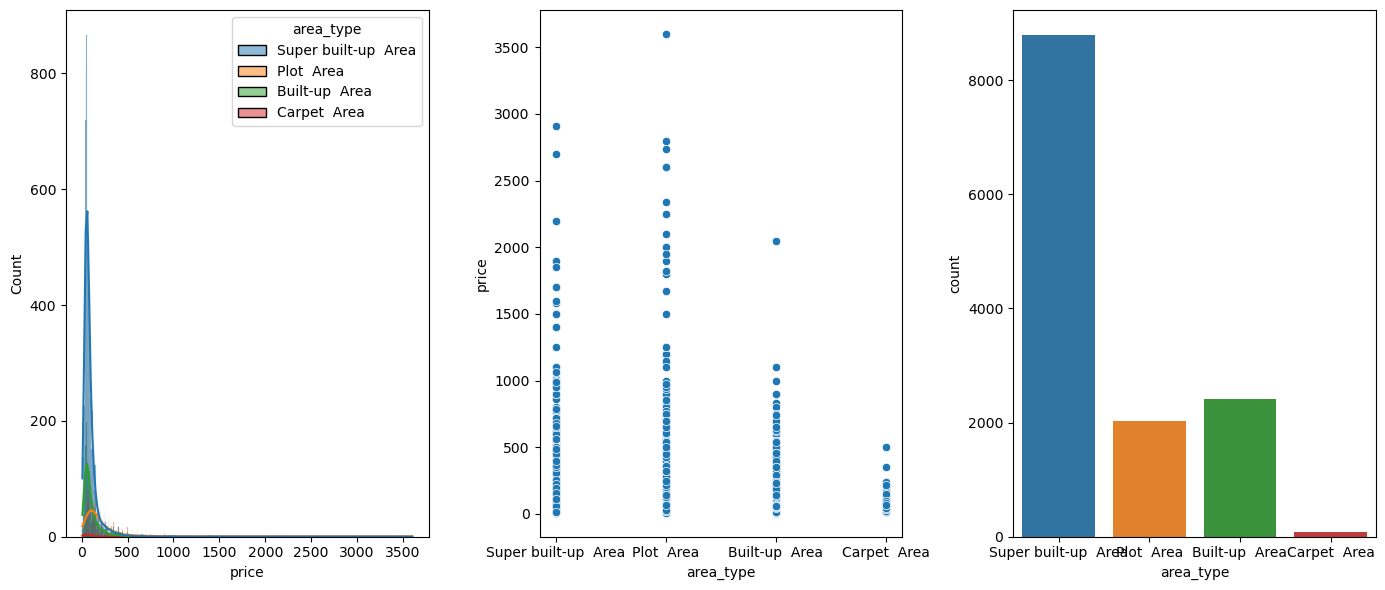

In [11]:
render_plot(df, 'price', 'area_type')

From the above graph, we can conclude that price range is almost irrespective of area_type, including area_type as an independent feature will add some serious noise to our model accuracy.

In [12]:
to_be_removed = ['area_type']

Checking the same for availability column

In [13]:
df.groupby('availability').agg({'price': [np.mean, np.max, np.min]})

price                 
                            mean     amax    amin
availability                                     
14-Jul                 43.710000    43.71   43.71
14-Nov                 43.710000    43.71   43.71
15-Aug                 62.000000    62.00   62.00
15-Dec                130.000000   130.00  130.00
15-Jun                 97.000000    97.00   97.00
...                          ...      ...     ...
22-Mar                 49.000000    70.00   30.00
22-May                225.500000   400.00  100.00
22-Nov                 78.370000    79.15   77.59
Immediate Possession   98.921875   460.00    8.44
Ready To Move         115.179137  3600.00    8.00

[81 rows x 3 columns]

In [14]:
# Matching pattern based on `dt-mon` and setting that values as `on later date`
pattern = '\d{1,2}-[a-z,A-Z]{3}'

df.loc[df.availability.str.match(pattern), 'availability'] = "On Later Date"

df.groupby('availability').agg({'price': [np.mean, np.max, np.min]})

price               
                            mean    amax   amin
availability                                   
Immediate Possession   98.921875   460.0   8.44
On Later Date         102.490248  2912.0  10.00
Ready To Move         115.179137  3600.0   8.00

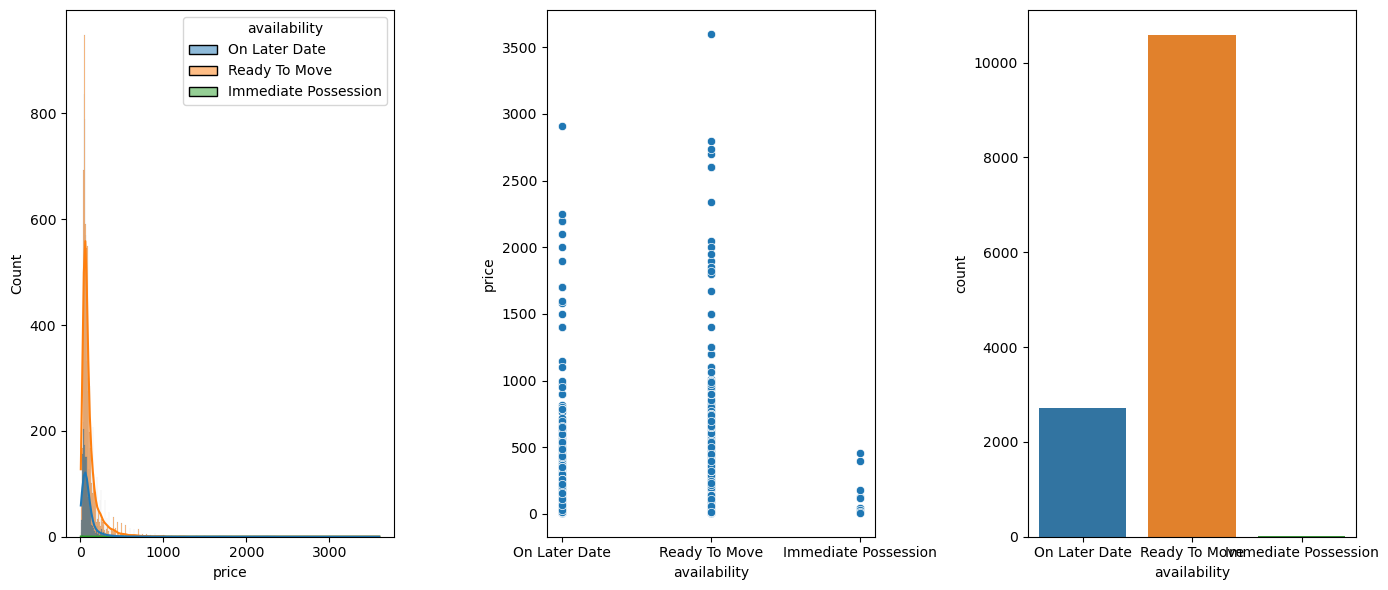

In [15]:
render_plot(df, 'price', 'availability')

As we can see, all Later Date and ready to move category price range collides with each other, so removing this `availability` column is better option guess

In [16]:
to_be_removed.append('availability')

Looking into the location fields now, filtered and set all location which has a frequencies of less than or equal to 10

In [17]:
low_freq_loc_lists = df.groupby('location').filter(lambda x: len(x) <= 10)['location'].tolist()

df.loc[df['location'].isin(low_freq_loc_lists), 'location'] = 'Other'

In [18]:
df['size'].value_counts()

2 BHK         5199
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 Bedroom       2
11 BHK           2
10 BHK           2
27 BHK           1
12 Bedroom       1
43 Bedroom       1
16 BHK           1
14 BHK           1
19 BHK           1
13 BHK           1
18 Bedroom       1
Name: size, dtype: int64

As almost all values indicates the bedroom, 1 indicates `rk` which means one room kitchen, quite similar to 1 bhk. So we will extract integers from size column

In [19]:
df['size'].fillna('0 bhk', inplace=True)

df['bhk_size'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

# Resetting the 0 bhk value by mean integer
df.loc[df['bhk_size'] == 0, :]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk_size
579,Plot Area,Immediate Possession,Sarjapur Road,0 bhk,Asiss B,1200 - 2400,NaN,NaN,34.185,0
1775,Plot Area,Immediate Possession,Other,0 bhk,Orana N,2000 - 5634,NaN,NaN,124.000,0
2264,Plot Area,Immediate Possession,Banashankari,0 bhk,NaN,2400,NaN,NaN,460.000,0
2809,Plot Area,Immediate Possession,Sarjapur Road,0 bhk,AsdiaAr,1200 - 2400,NaN,NaN,28.785,0
2862,Plot Area,Immediate Possession,Devanahalli,0 bhk,Ajleyor,1500 - 2400,NaN,NaN,46.800,0
5333,Plot Area,Immediate Possession,Devanahalli,0 bhk,Emngs S,2100 - 5405,NaN,NaN,177.115,0
6423,Plot Area,Immediate Possession,Whitefield,0 bhk,SRniaGa,2324,NaN,NaN,26.730,0
6636,Plot Area,Immediate Possession,Jigani,0 bhk,S2enste,1500,NaN,NaN,25.490,0
6719,Plot Area,Immediate Possession,Hoskote,0 bhk,SJowsn,800 - 2660,NaN,NaN,28.545,0
7680,Plot Area,Immediate Possession,Kasavanhalli,0 bhk,NaN,5000,NaN,NaN,400.000,0


In [20]:
# now we need to reset 0 bhk by its mean
print('Mean price of 0 bhk is', format(df.loc[df['bhk_size'] == 0, 'price'].mean()))

print('Dataset bhk_size mean is', format(round(df['bhk_size'].mean())))

print('Mean price of 3 bhk is', format(df.loc[df['bhk_size'] == 3, 'price'].mean()))

Mean price of 0 bhk is 98.92187499999999
Dataset bhk_size mean is 3
Mean price of 3 bhk is 110.95232550957365


In [21]:
df.loc[df['bhk_size'] == 0, 'bhk_size'] = round(df['bhk_size'].mean())

In [22]:
# Society already has almost 45% null data, so we will remove society, also size as we've created bhk_size column
to_be_removed.extend(['society', 'size'])

In [23]:
to_be_removed

['area_type', 'availability', 'society', 'size']

looking at the bath & balcony category

In [24]:
df['bath'].fillna(round(df['bath'].mean()), inplace=True)

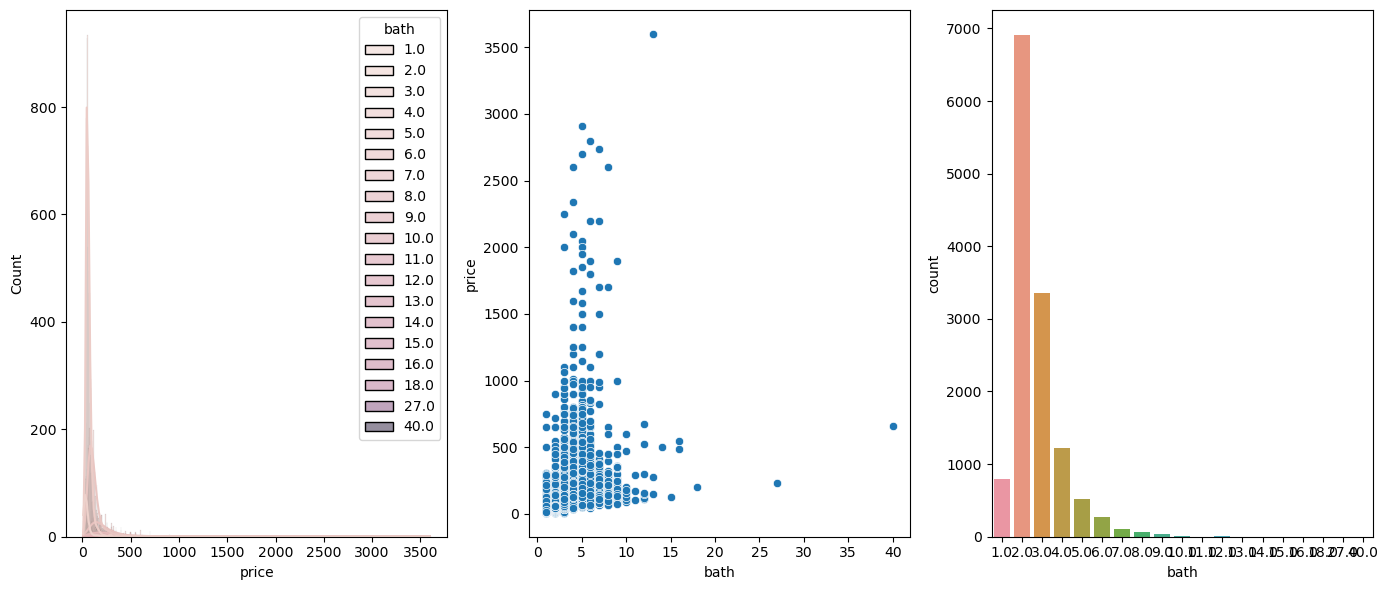

In [25]:
render_plot(df, 'price', 'bath')

In [26]:
df['balcony'].fillna(round(df['balcony'].mean()), inplace=True)

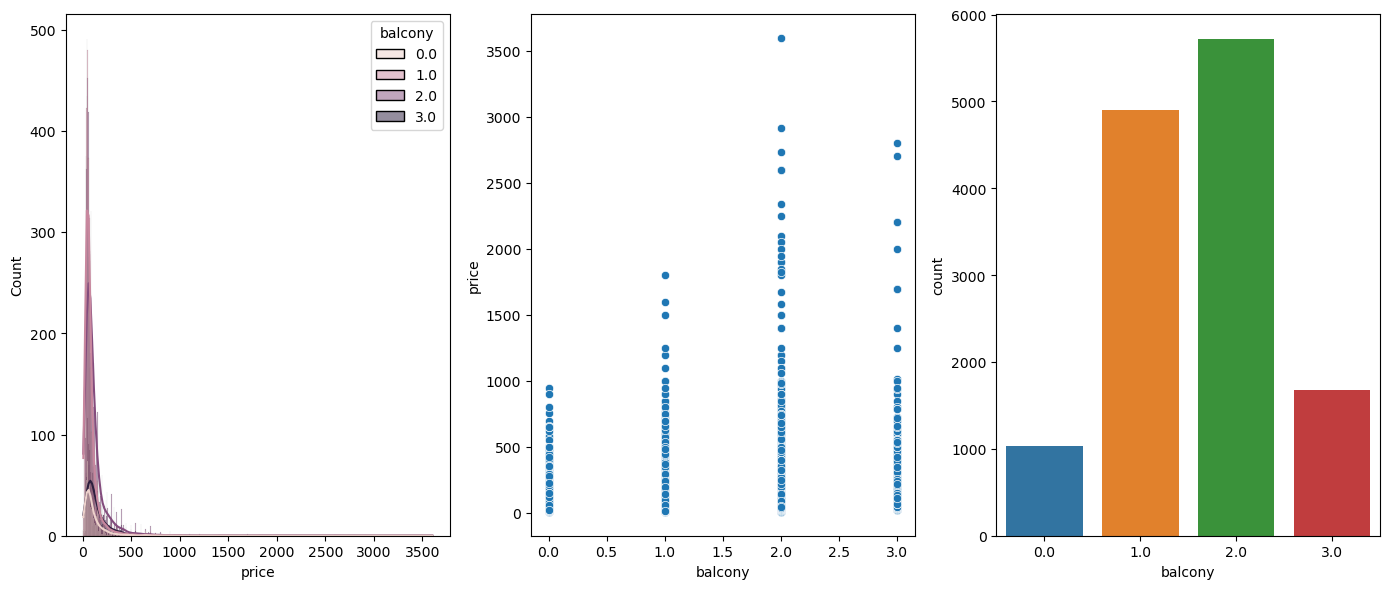

In [27]:
render_plot(df, 'price', 'balcony')

In [28]:
def extract_numerical_sqft(ft):
    token = ft.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1]))/2
    try:
        return float(ft)
    except:
        return 0
    
df['total_sqft'] = df['total_sqft'].apply(extract_numerical_sqft)

In [29]:
df['location'].fillna('Other', inplace=True)

Creating a new column price_per_sq_ft = total_sq_ft / price

In [30]:
df['price_per_sqft'] = round(df['total_sqft']/ df['price'], 2)

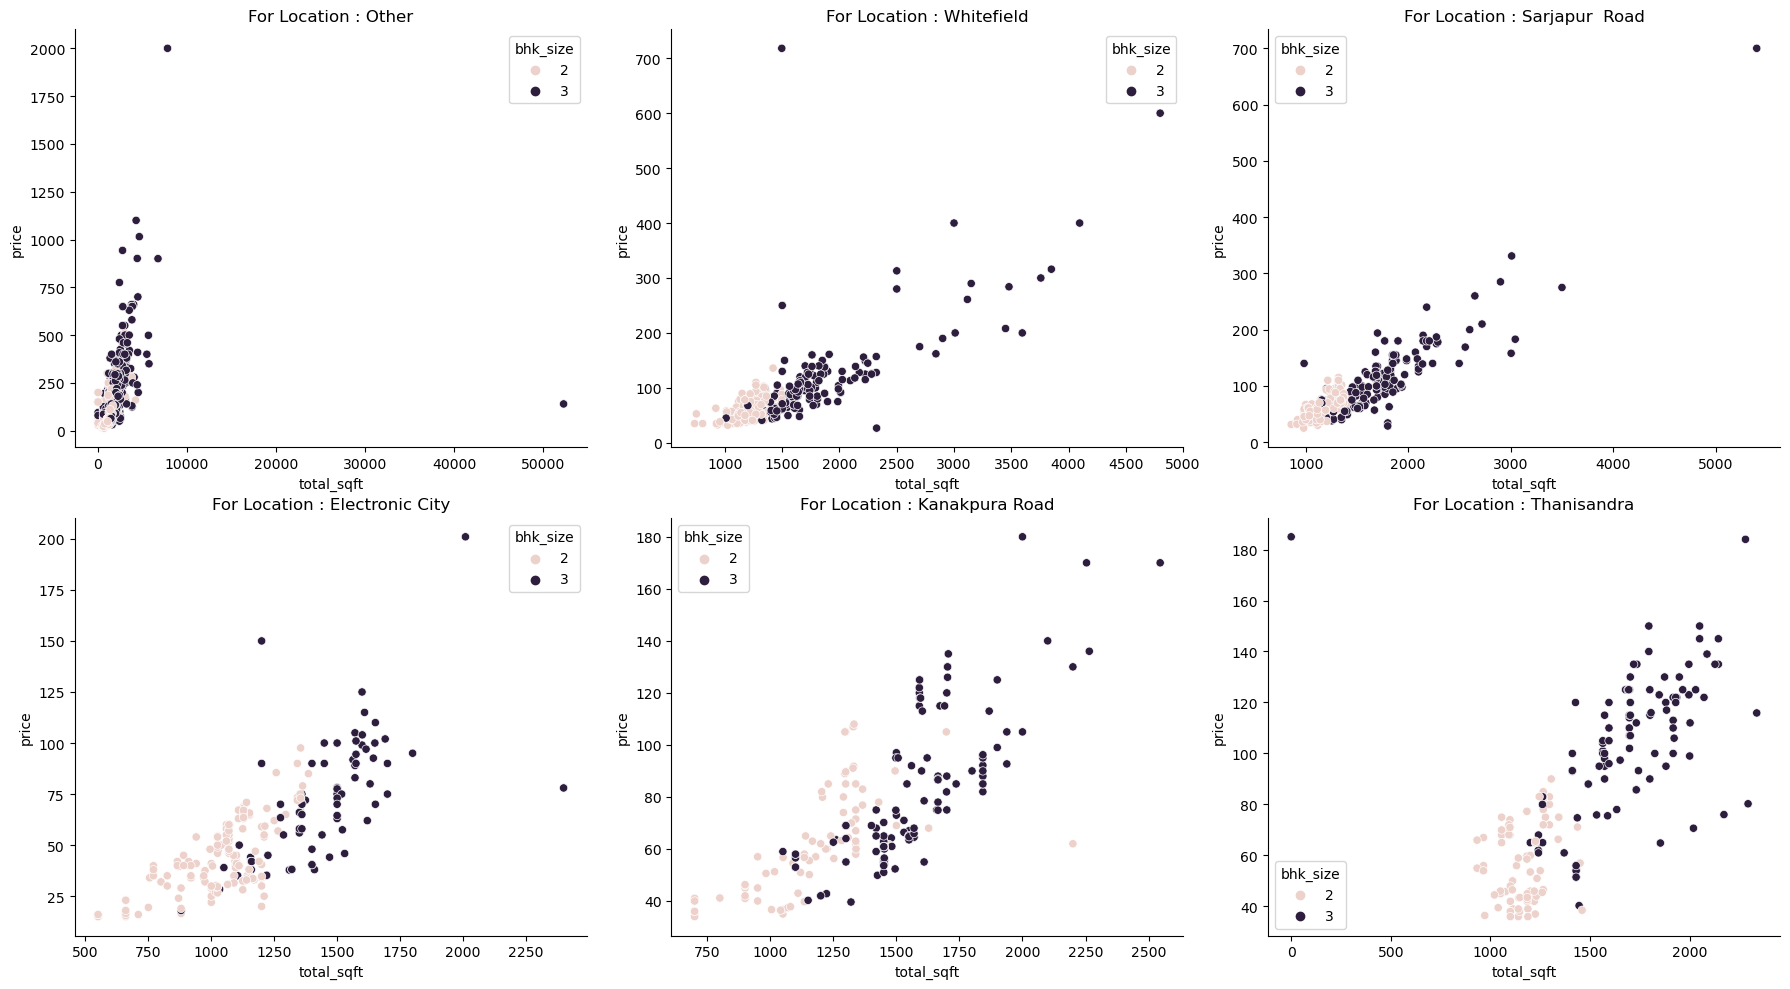

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.scatterplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],\
        x='total_sqft', y='price', hue='bhk_size', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

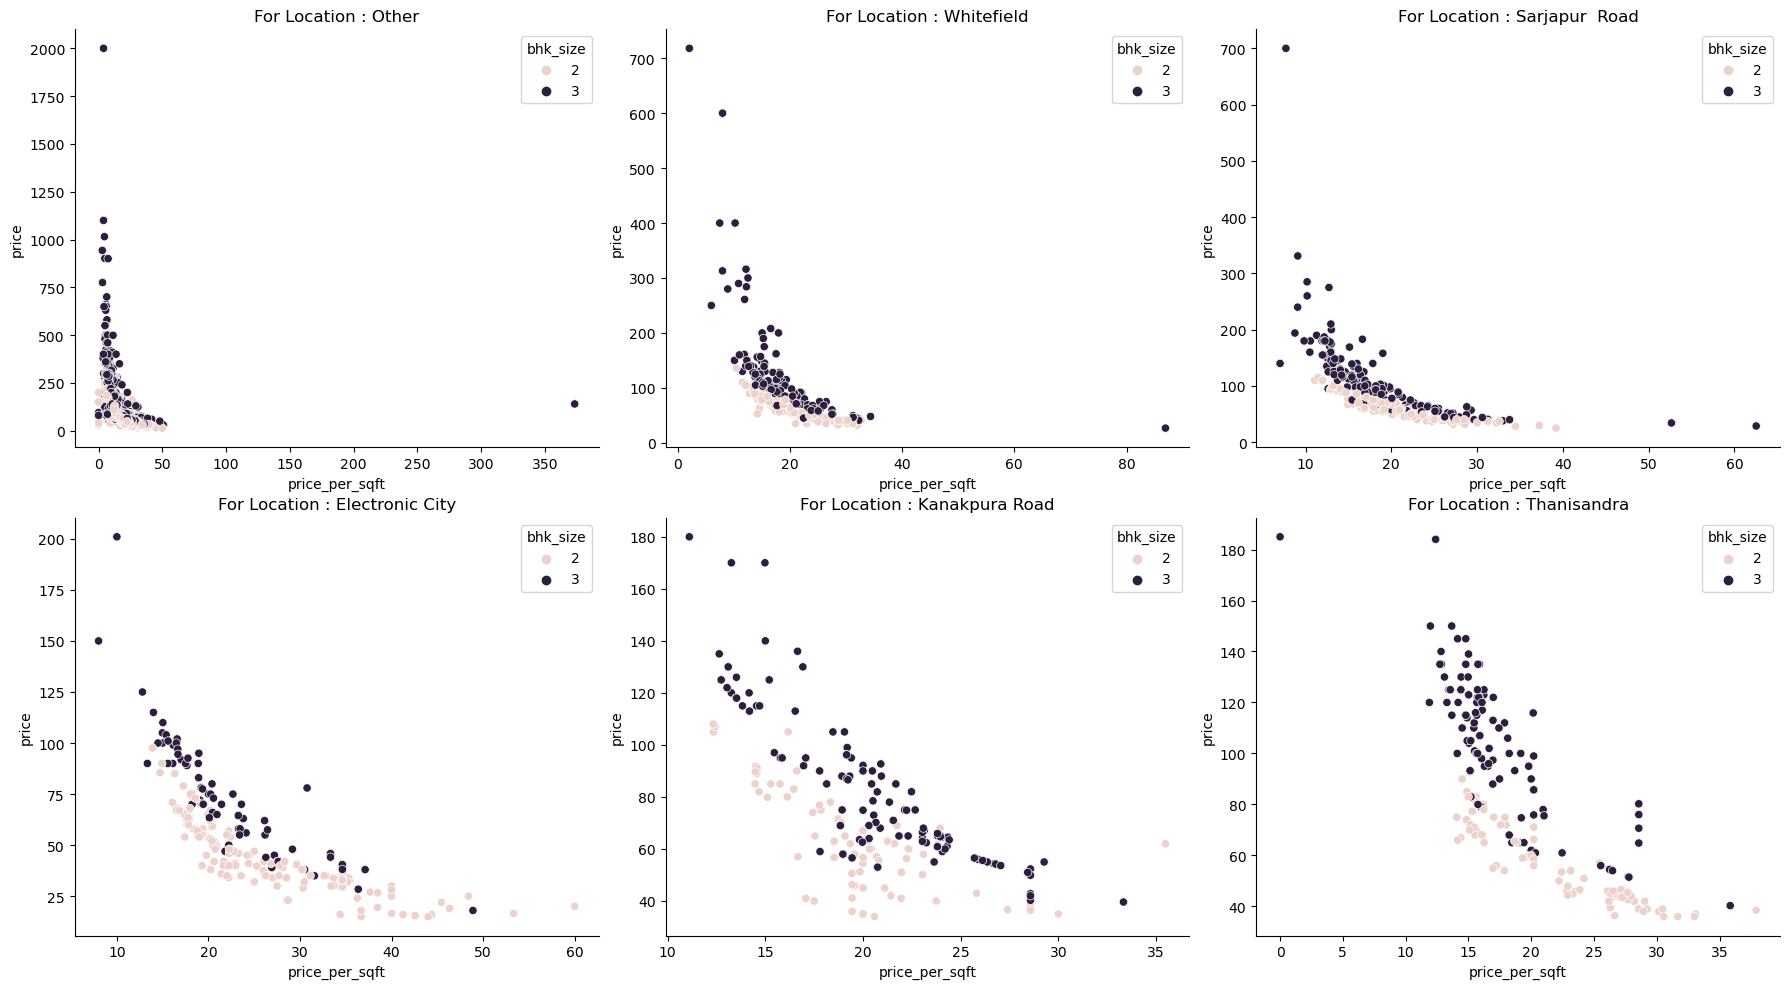

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.scatterplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],\
        x='price_per_sqft', y='price', hue='bhk_size', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

On the above graph we can notice a trend where price & price_per_sqft shares a negative linear relation, the more the price, the less the price per sq ft

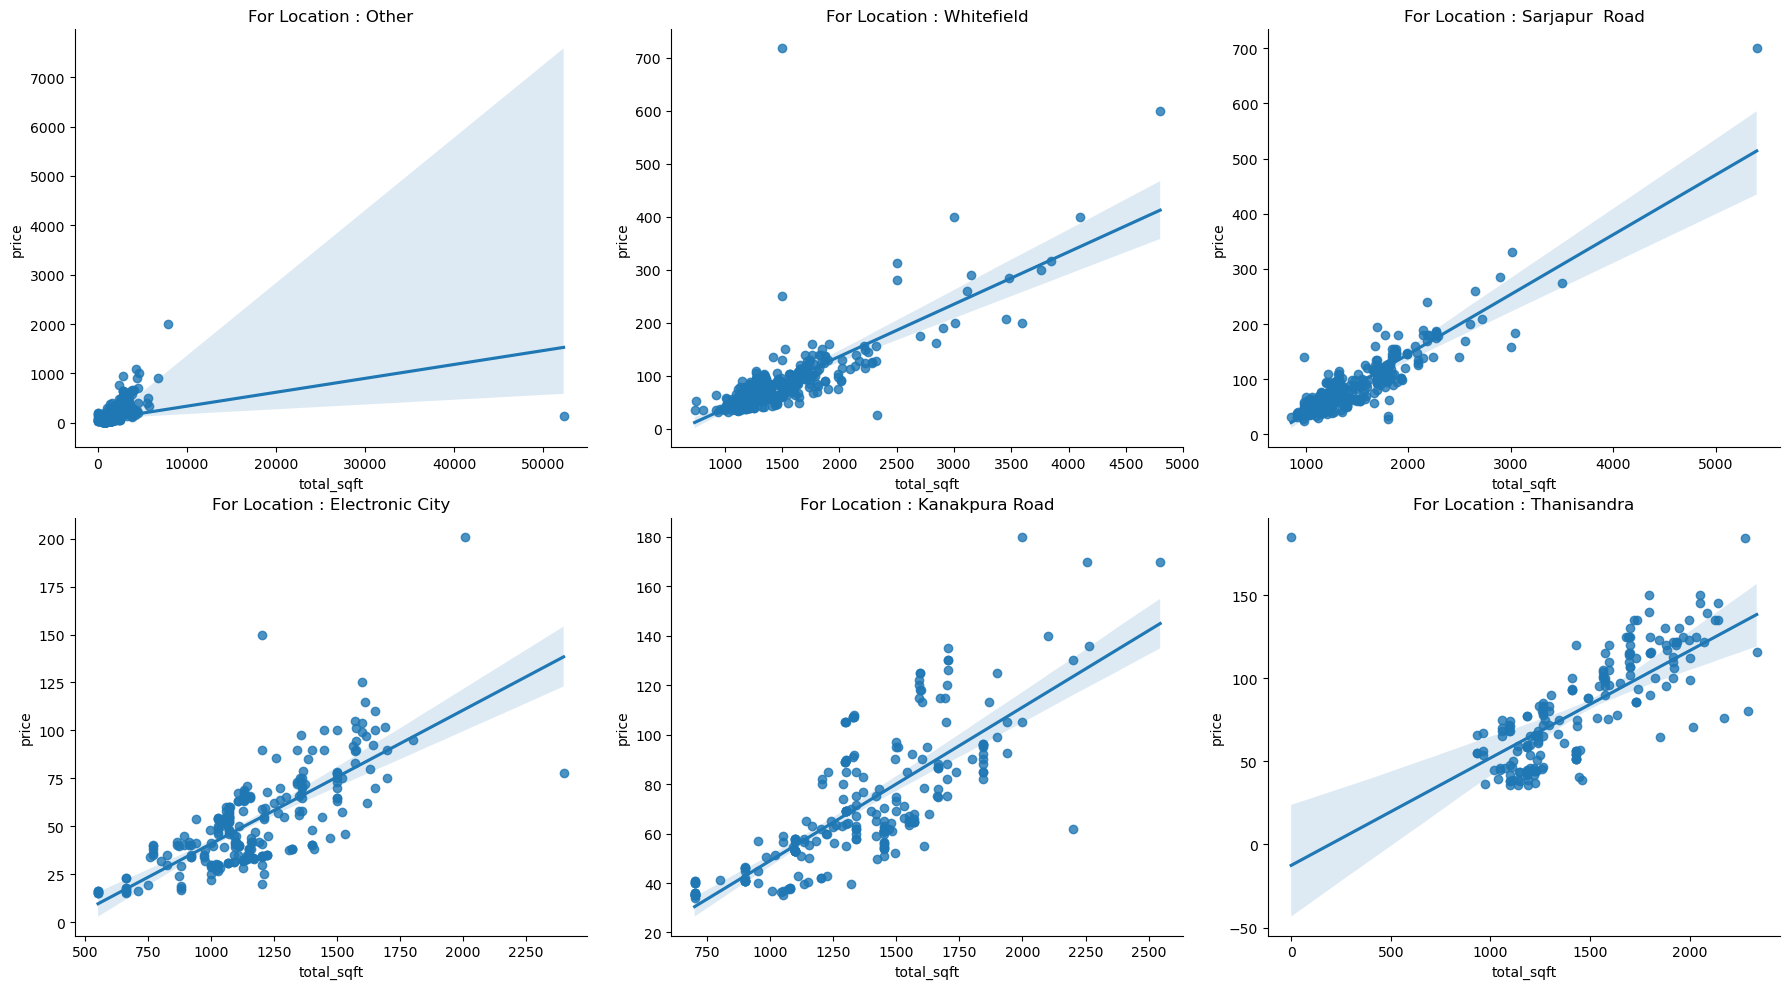

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.regplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],\
        x='total_sqft', y='price', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

Other
Whitefield
Sarjapur  Road
Electronic City
Kanakpura Road
Thanisandra


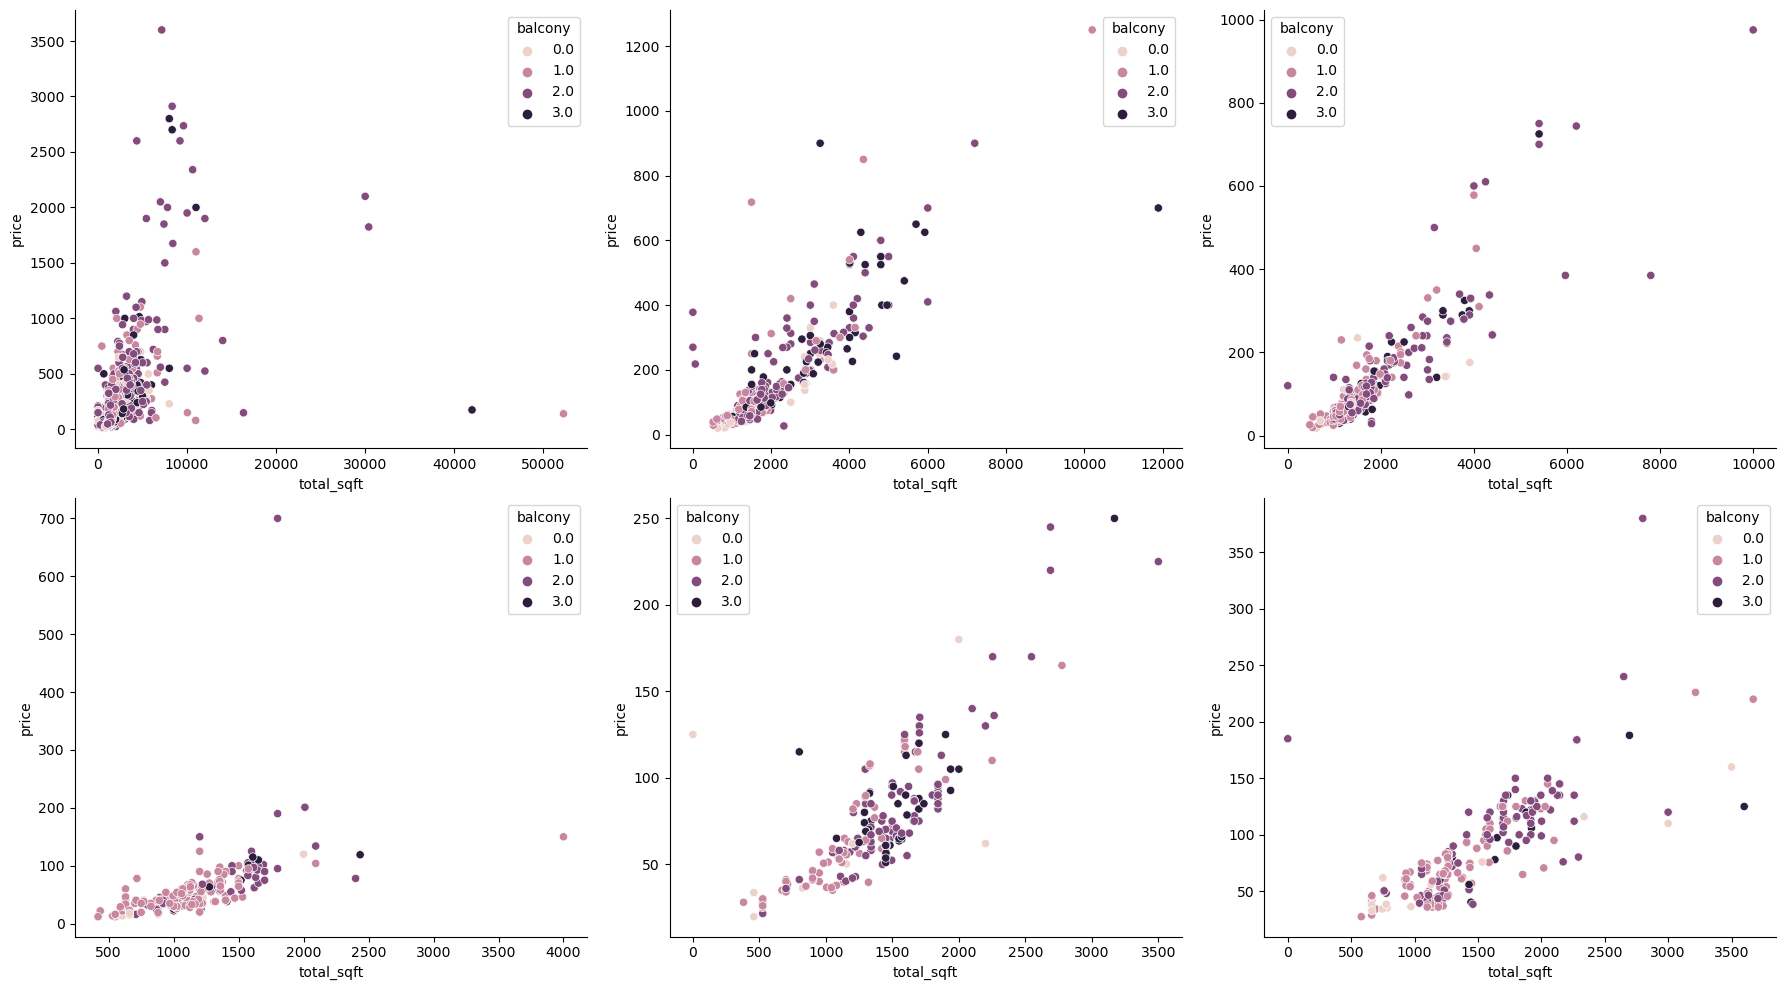

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    print(loc)
    sns.scatterplot(data=df.loc[df['location'] == loc, :],\
        x='total_sqft', y='price', hue='balcony', ax=ax)
    sns.despine()
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

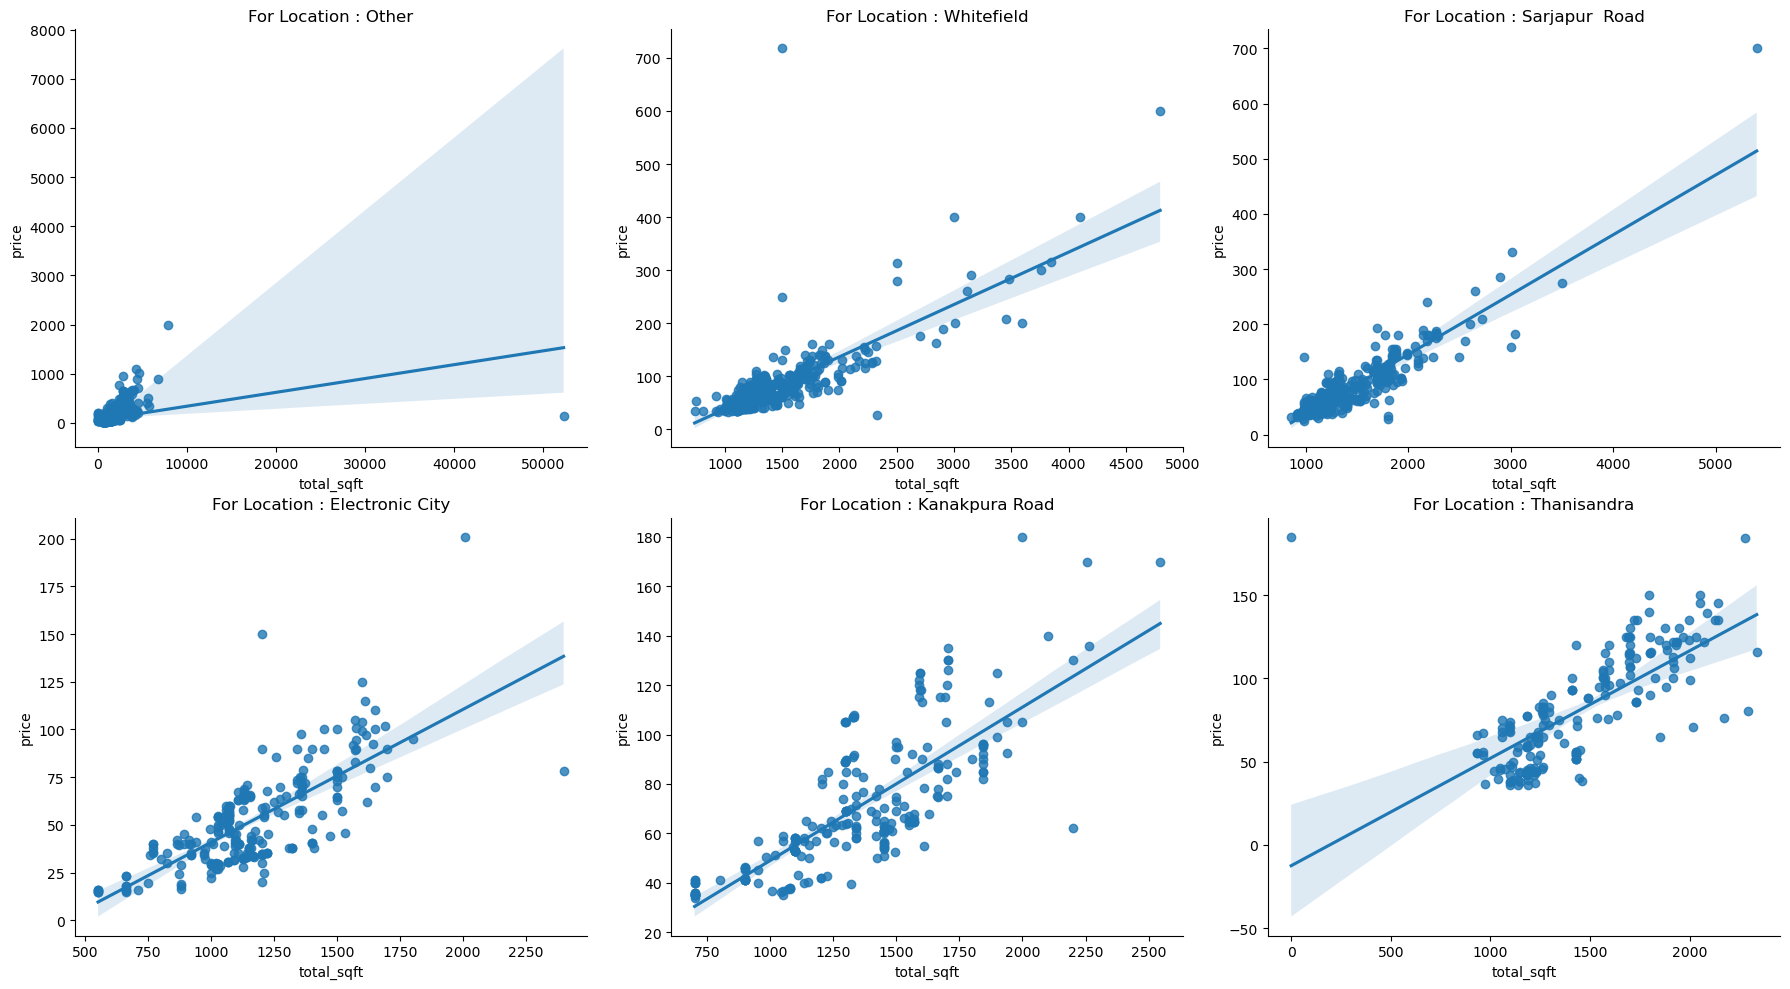

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.regplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],\
        x='total_sqft', y='price', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

In [36]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk_size,price_per_sqft
0,Super built-up Area,On Later Date,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2,27.03
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4,21.67
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3,23.23
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3,16.01
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2,23.53
...,...,...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453.0,4.0,0.0,231.00,5,14.95
13316,Super built-up Area,Ready To Move,Other,4 BHK,NaN,3600.0,5.0,2.0,400.00,4,9.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141.0,2.0,1.0,60.00,2,19.02
13318,Super built-up Area,On Later Date,Padmanabhanagar,4 BHK,SollyCl,4689.0,4.0,1.0,488.00,4,9.61


Handling Skewed Data

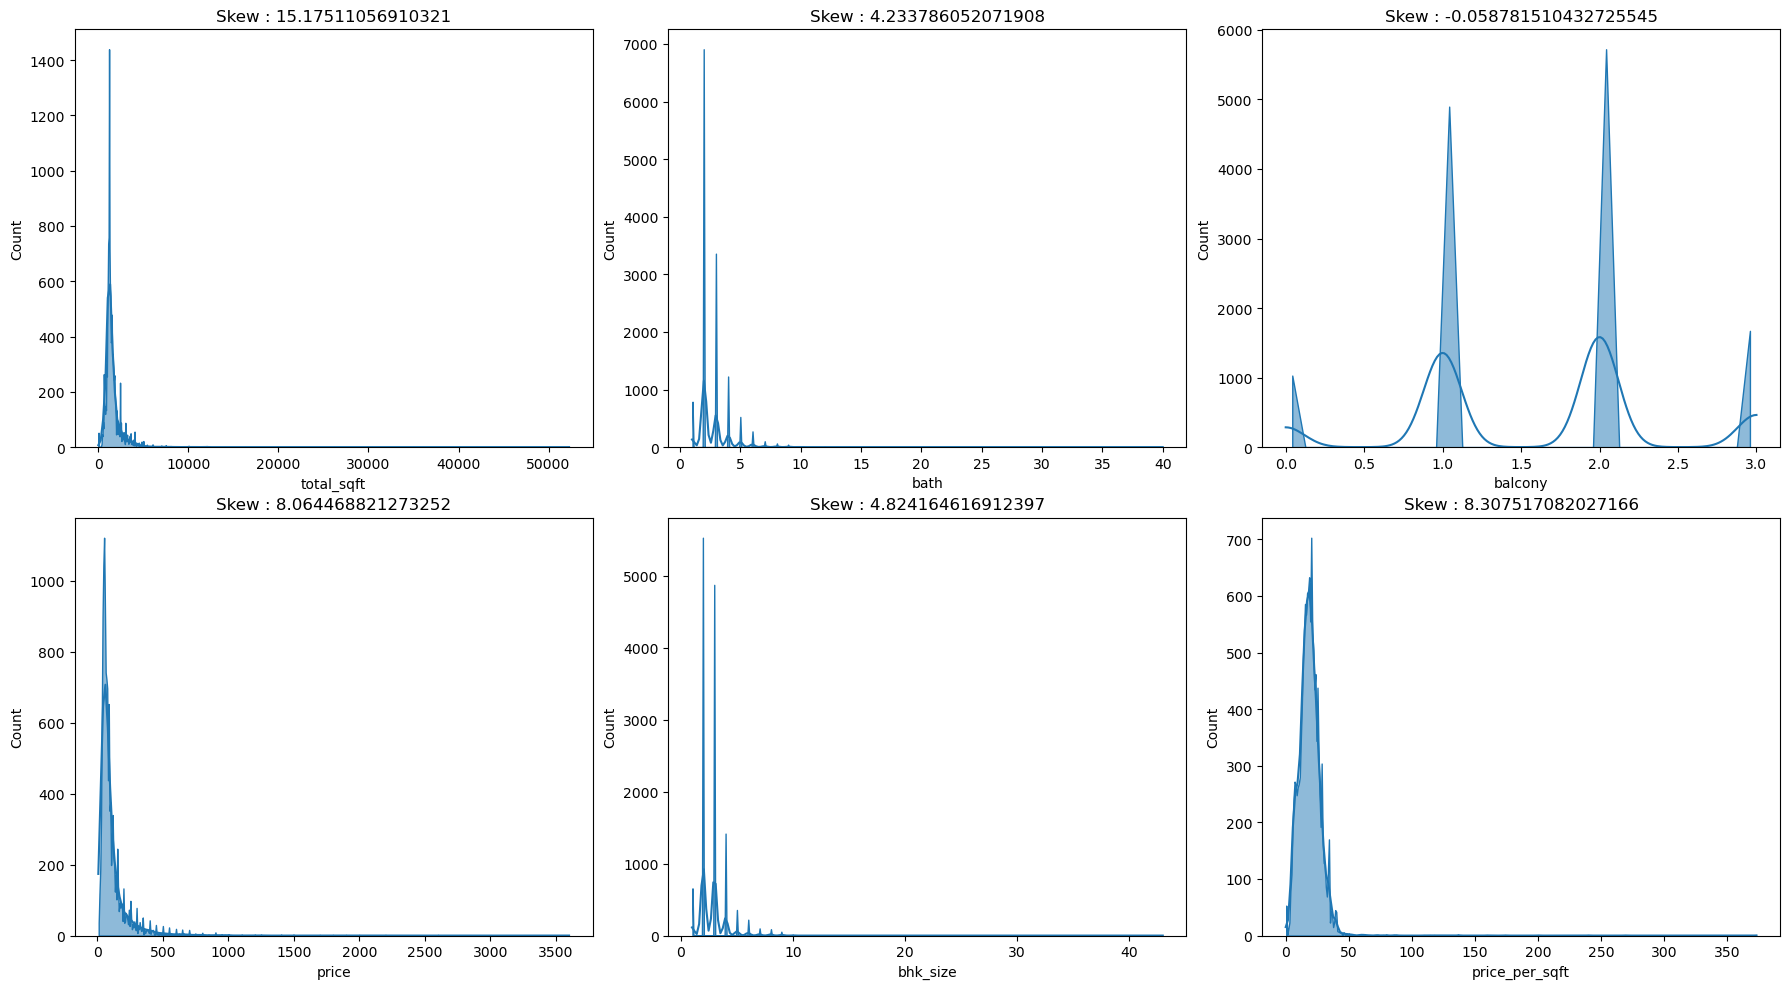

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    sns.histplot(x=col, data=df, ax=ax, kde=True, element='poly')
    ax.set_title(f'Skew : {df[col].skew()}')
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

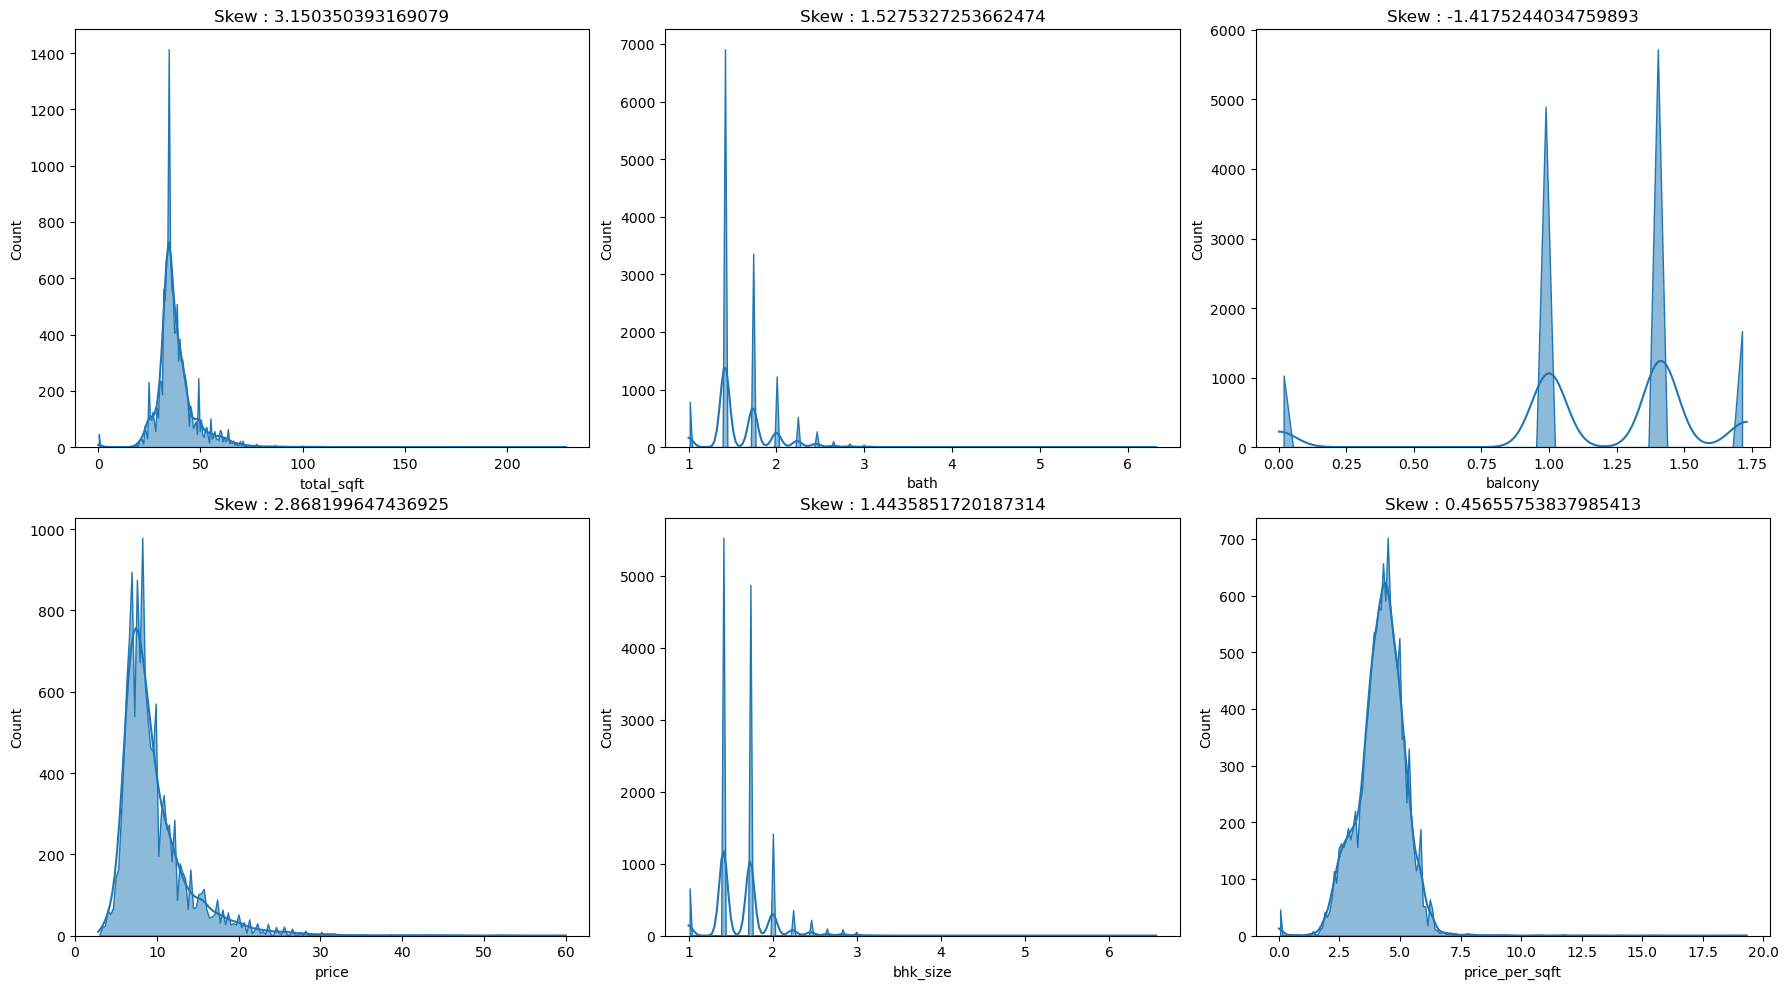

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    df[col] = np.sqrt(df[col])
    sns.histplot(x=col, data=df, ax=ax, kde=True, element='poly')
    ax.set_title(f'Skew : {df[col].skew()}')
    
plt.tight_layout(h_pad=0.5, w_pad=0.8)

In [39]:
# Taking a look at the distribution of balcony, we should remove it
to_be_removed.append('balcony')

Removing Outliers

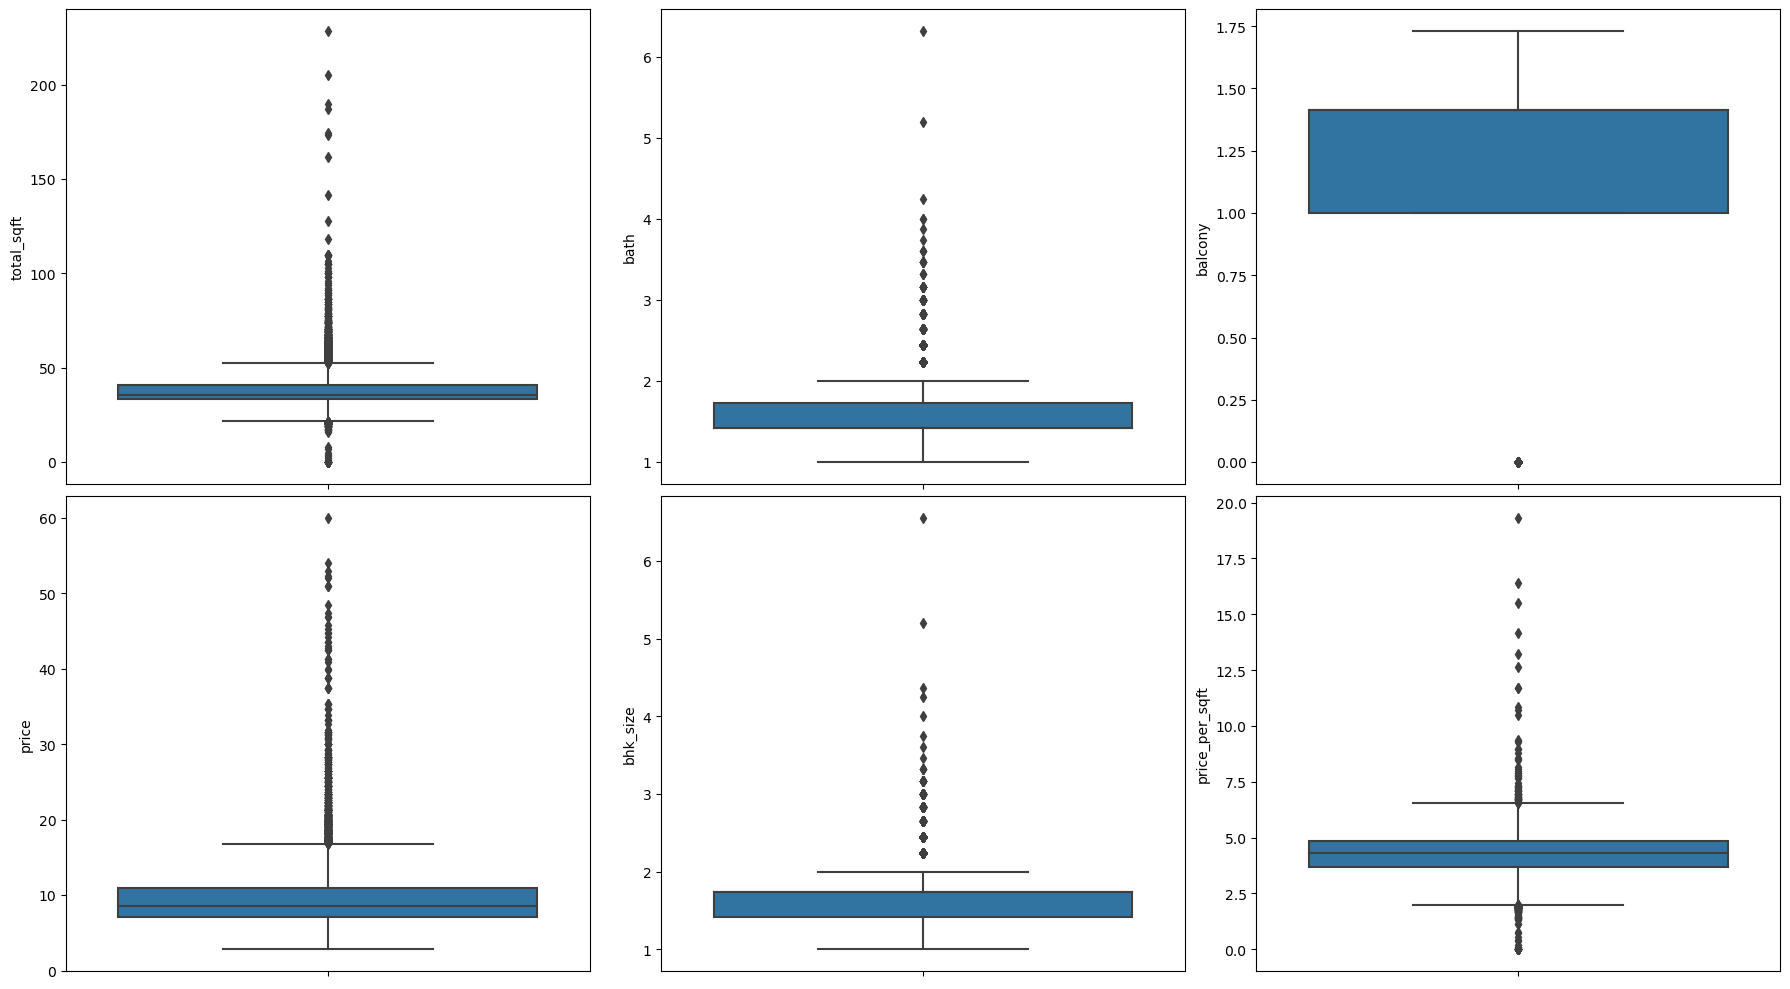

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    sns.boxplot(y=col, data=df, ax=ax)

plt.tight_layout(h_pad=0.5, w_pad=0.8)

In [41]:
df_filtered = df.copy()
for col in df.select_dtypes(include=np.number).columns.tolist():
    miu = np.mean(df[col])
    sigma = np.std(df[col])
    
    df_filtered = df_filtered.loc[(df[col] > (miu - 2*sigma)) & (df[col] < (miu + 2*sigma))]

df_filtered.shape, df.shape

((10880, 11), (13320, 11))

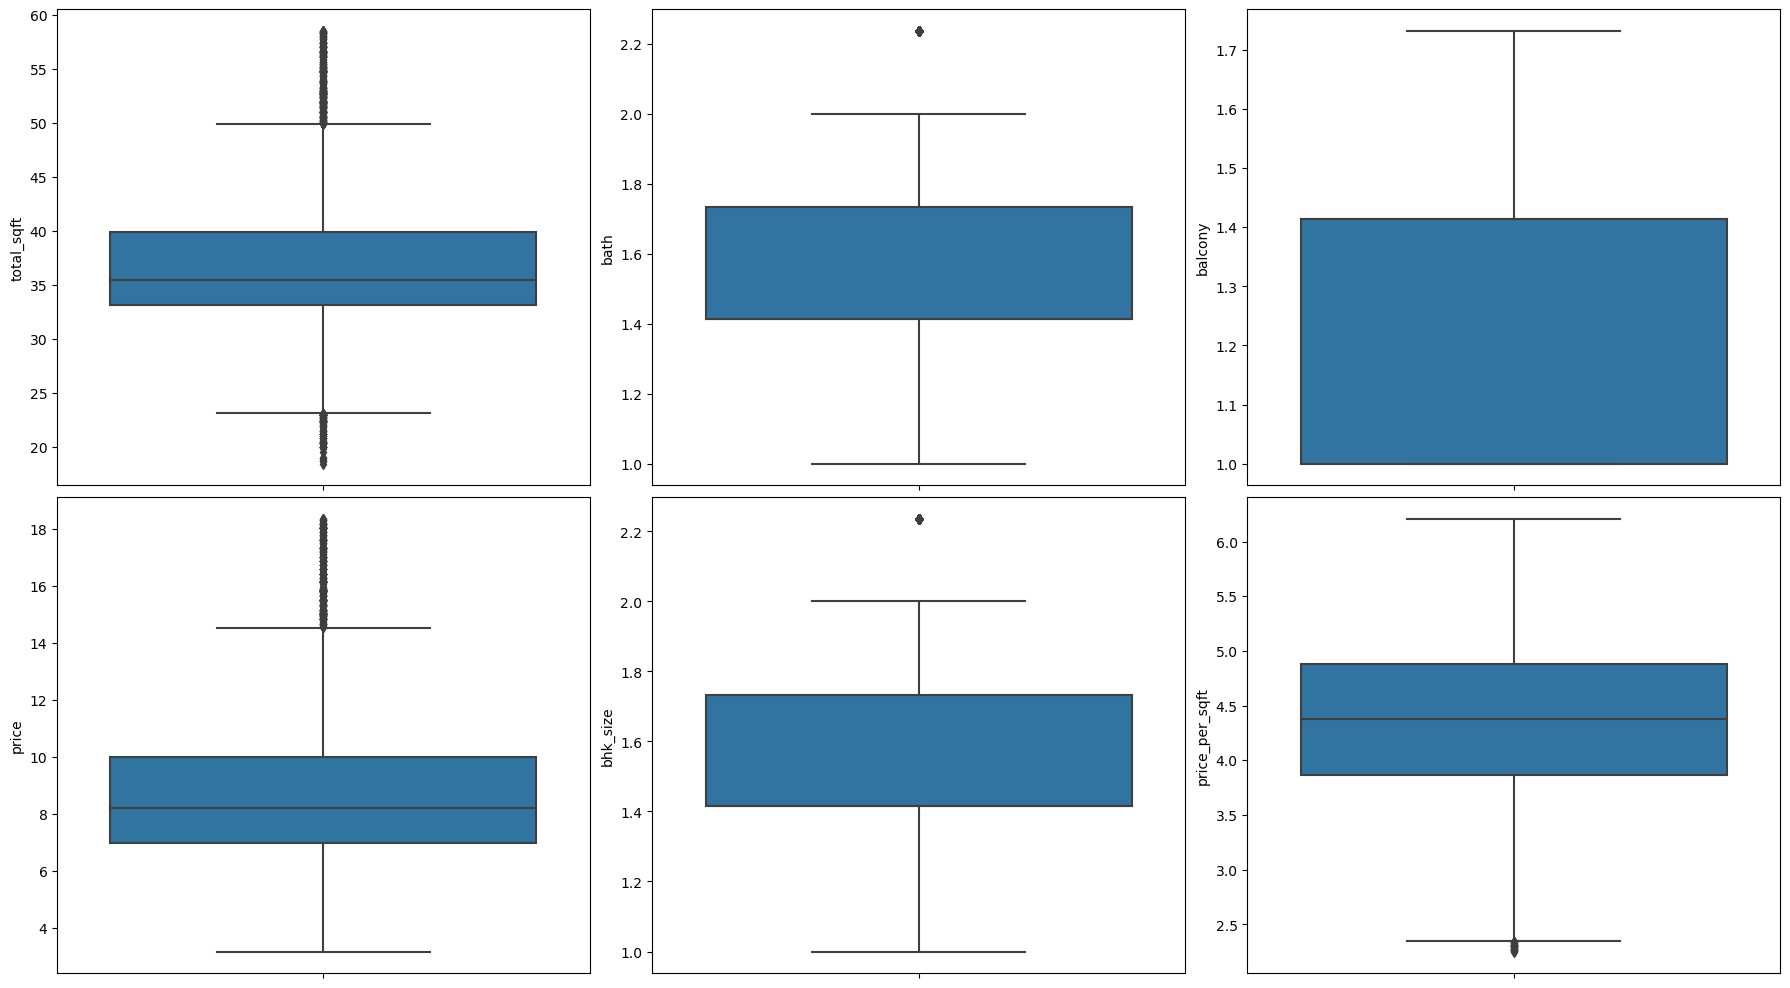

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df_filtered.select_dtypes(include=np.number).columns.tolist(), axes):
    sns.boxplot(y=col, data=df_filtered, ax=ax)

plt.tight_layout(h_pad=0.5, w_pad=0.8)

Data is much clearer now, now removing the excluded columns from the list created

In [43]:
# Removing price_per_sqft column, we can't consider it as a feature coz it contains
# target variable and could be a reason to data leakage
to_be_removed.append('price_per_sqft')

df_filtered.drop(np.unique(to_be_removed), axis=1, inplace=True)
df_filtered

,location,total_sqft,bath,price,bhk_size
0,Electronic City Phase II,32.496154,1.414214,6.250600,1.414214
1,Chikka Tirupathi,50.990195,2.236068,10.954451,2.000000
2,Uttarahalli,37.947332,1.414214,7.874008,1.732051
3,Lingadheeranahalli,39.000000,1.732051,9.746794,1.732051
4,Kothanur,34.641016,1.414214,7.141428,1.414214
...,...,...,...,...,...
13312,Bellandur,35.524639,1.414214,6.855655,1.414214
13313,Uttarahalli,36.674242,1.414214,7.549834,1.732051
13314,Green Glen Layout,41.412558,1.732051,10.583005,1.732051
13317,Raja Rajeshwari Nagar,33.778692,1.414214,7.745967,1.414214


In [44]:
# just to make price the last column, so heatmap looks better lol :D
df_price = df_filtered['price']
df_filtered.drop('price', axis=1, inplace=True)
df_filtered['price'] = df_price

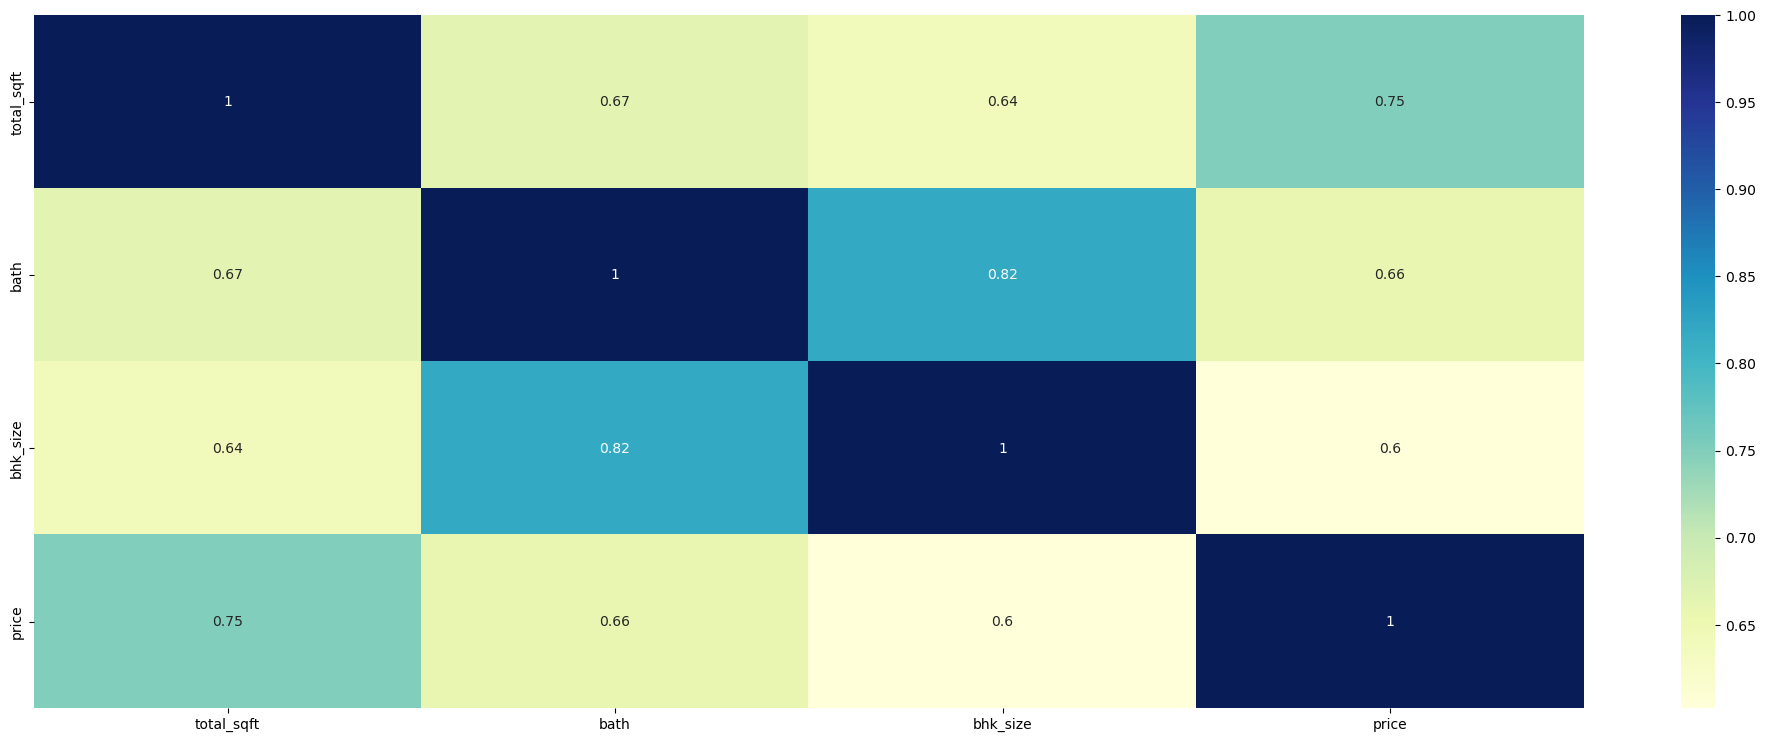

In [45]:
plt.figure(figsize=(25,9))
sns.heatmap(df_filtered.corr(), cmap="YlGnBu", annot=True)
plt.show()

we see a quiet high relation between bhk_size and bath

In [46]:
df_filtered_ver2 = pd.concat([df_filtered, pd.get_dummies(df_filtered['location'])], axis=1)
df_filtered_ver2.drop('location', axis=1, inplace=True)

In [47]:
X = df_filtered_ver2.drop('price', axis=1)
y = df_filtered_ver2['price']

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def model_rndsearch(X_train, y_train, X_test, y_test):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                'selection': ['random', 'cyclic'],
                'max_iter': [100, 500, 1000, 2000]
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1, 0.1, 0.01, 0.001, 0.0001]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'bootstrap': [True],
                 'max_depth': [50, 60],
                 'max_features': ['sqrt'],
                 'min_samples_leaf': [1],
                 'min_samples_split': [5],
                 'n_estimators': [600, 800]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        # creating randomsearch cross validation and fitting with train data
        rs =  RandomizedSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
        rs.fit(X_train, y_train)
        
        # to collect score with test data
        y_pred = rs.predict(X_test)
        
        scores.append({
            'model': algo_name,
            'best_score': rs.best_score_,
            'r2_score_on_test': r2_score(y_test, y_pred),
            'mse_on_test': mean_squared_error(y_test, y_pred),
            'best_params': rs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'r2_score_on_test', 'mse_on_test', 'best_params'])

model_df = model_rndsearch(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
model_df

The best model performance is on random_forest, so now we are training the same model with best params acquired from RandomizedSearchCV

In [ ]:
rf_model = RandomForestRegressor(n_estimators=800, min_samples_split=5, min_samples_leaf=1,
             max_features='sqrt', max_depth=60, random_state=7)

rf_model.fit(X_train,y_train)

In [ ]:
def print_error_metrics(test, pred):
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    rtwoscore = r2_score(test, pred)
    adjusted_r2 = 1-(1-rtwoscore)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("MSE : ", mse)
    print("RMSE : ", rmse)
    print("R2 SCORE : ", rtwoscore)
    print("Adjusted R2 SCORE : ", adjusted_r2)

In [ ]:
y_pred = rf_model.predict(X_test)

print_error_metrics(y_test, y_pred)

In [ ]:
plt.figure(figsize=(24,10))
plt.plot(y_pred[:500]**2)
plt.plot(np.array(y_test[:500]**2))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

In [ ]:
sns.regplot(y_test**2, y_pred**2)
plt.xlabel('Actual selling price')
plt.ylabel('Predicted selling price')
plt.show()

In [ ]:
#Resuldual Analysis
fig = plt.figure(figsize=(8,8))
sns.histplot((y_test**2- y_pred**2), bins=20, color='r', stat='density', kde=True, element='poly')
fig.suptitle('Residual Analysis', fontsize = 20)
sns.despine()

In [ ]:
def price_predict(total_sqft, bath, bhk_size, location):
    x = np.zeros(X.shape[1])
    x[0] = np.sqrt(total_sqft)
    x[1] = np.sqrt(bath)
    x[2] = np.sqrt(bhk_size)
    
    try:
        loc_index = np.where(X.columns.str.lower() == location.lower())[0][0]
    except IndexError:
        print("Location not found, using `Other`.")
        loc_index = np.where(X.columns.str.lower() == 'other')[0][0]
    finally:
        x[loc_index] = 1
        
    x = scaler.transform(x.reshape(1, -1))
    return rf_model.predict(x)**2

In [ ]:
# Actual Price is 39
price_predict(1056, 2, 2, 'Electronic City Phase II')

In [ ]:
# Actual Price is 95
price_predict(1521, 3, 3, 'Lingadheeranahalli')

In [ ]:
import pickle

with open('banglore_home_prices_prediction_model.pickle','wb') as f:
    pickle.dump(rf_model,f)

with open('banglore_home_prices_prediction_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
import json
columns = {
    'data_columns': [col for col in X.columns]
}
with open("banglore_home_prices_prediction_columns.json","w") as f:
    f.write(json.dumps(columns))